In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
from matplotlib import pyplot
import sys
from IPython import display

# Weather analysis

In [2]:
from IPython import display
#display.Image("https://frasissime.com/wp-content/uploads/2020/09/frasi-sul-tempo-atmosferico-1200x675.jpg")

The second part of this analysis is taking in account also the weather during my working hours, I'll try to find correlation and interesting insights.

In [3]:
path = sys.path[0]
df= pd.read_csv(path+'/Work_analysis.csv')
df['date']=pd.to_datetime(df.date,dayfirst=True)
df=df.astype({   #transforming every columns in a usefull type
    'etips':'float',
    'cash': 'float',
    'deliveries':'int64',
    'km':'float',
    'hrs':'int64',
    'earnings':'float',
    'net':'float',
    'nethrs':'float',
    'strhr':'float'
    })

First of all I upload the previous DataFrame **df** containing statistical data of my activity as a courier.

In [4]:
import glob
path=path+'/meteo_csv'
all_files = glob.glob(path+ "/*.csv") #every csv is containing weather data over 1 week
#using glob I creat a list with all the name of the different .csv meteo files

l = []
for filename in all_files:
    l.append(pd.read_csv(filename, index_col=None, header=0))
# I open all the different csv and I put the in one list


In [5]:
# the list become a dataframe
frame = pd.concat(l, axis=0, ignore_index=True)
frame.drop(columns='snow',inplace=True) #I drop 'snow' column because is NaN
frame.head()


,time,time_local,temp,dwpt,rhum,prcp,wdir,wspd,wpgt,pres,tsun,coco
0,2021-03-20 23:00:00,2021-03-21 00:00:00,2.1,-3.8,65,0.0,230,24,31.0,1018.9,0,4
1,2021-03-21 00:00:00,2021-03-21 01:00:00,3.1,-2.8,65,0.0,240,24,35.0,1017.7,0,4
2,2021-03-21 01:00:00,2021-03-21 02:00:00,3.1,-2.8,65,0.0,240,24,35.0,1016.8,0,4
3,2021-03-21 02:00:00,2021-03-21 03:00:00,3.1,-0.9,75,0.0,250,26,38.0,1015.6,0,4
4,2021-03-21 03:00:00,2021-03-21 04:00:00,3.1,1.1,87,0.0,250,24,37.0,1014.6,0,7


In [6]:
frame.drop(['time'],axis=1, inplace= True)
frame.rename(columns={'time_local':'time'},inplace=True)
#I'm selecting only time_local which is taking account the time zone

In [7]:
date,hrs=[],[]
for el in frame.time:
    date.append(el.split(' ')[0])
    hrs.append(el.split(' ')[1])

frame['hr']=hrs 
frame['date']=date 

frame['date'] = pd.to_datetime(frame['date'])
frame['hr']=frame.hr.str[:2]

frame[['time','date','hr']].head(2) #from time column I get the hour of the days and the date

,time,date,hr
0,2021-03-21 00:00:00,2021-03-21,00
1,2021-03-21 01:00:00,2021-03-21,01


In [8]:
#both frame and df dataframes have date column, we'll merge them over this column
#when I'm not working I have no weather date
w=df.merge(right= frame,on= ['date'])

In [9]:
w.head(1)

,date,schedule,hrs,etips,cash,deliveries,km,earnings,net,nethrs,...,dwpt,rhum,prcp,wdir,wspd,wpgt,pres,tsun,coco,hr
0,2020-12-11,18-22,4,5.5,10.0,10,34.2,44.3,56.02,14.01,...,-1.9,93,0.0,100,11,18.0,1008.6,0,4,00


In [10]:
w['schedule']=w.schedule.str[:2] # I transform schedule from this: 18-22, to this: 18
w=w.astype({'hr':'int64','schedule':'int64'})

In [11]:
rang=[]
for el in range(len(w.cash)):
        a=w.hrs[el]+w.schedule[el]
        b=range(w.schedule[el],a)
        rang.append(b)

In [12]:
w['schedule']=rang #I transfomr schedule from a sigle number to a range (eg. 18 -> (18,19,20,21))
w.drop(['time','wdir'],axis=1, inplace= True) #I drop obsolete time and useless wind direction column 

In [13]:
w.head(1)

,date,schedule,hrs,etips,cash,deliveries,km,earnings,net,nethrs,...,temp,dwpt,rhum,prcp,wspd,wpgt,pres,tsun,coco,hr
0,2020-12-11,"(18, 19, 20, 21)",4,5.5,10.0,10,34.2,44.3,56.02,14.01,...,-0.9,-1.9,93,0.0,11,18.0,1008.6,0,4,0


In [14]:
filt=[]
for el in range(len(w.day)):
    filt.append(w.hr[el] in w.schedule[el]) #boolean if hours of the days are the hours of my shift

w=w[filt]
w.fillna(0,inplace=True)

In [15]:
get_max= lambda x: x.value_counts(dropna=False).index[0] # creating a function that get the mode value from a set

In [16]:
f1={'etips':'median',
    'cash':'median',
    'deliveries':'median',
    'km':'median',
    'hrs':'median',
    'nethrs':'median',
    'tipdel':'median',
    'kmdel':'median',
    'delhrs':'median',
    'more':'median',
    'temp':'median',
   'dwpt':'median',
  'rhum':'median',
    'prcp':'mean',
   'wspd':'mean',
  'wpgt':'mean',
   'pres':'mean',
    'hr':'min'
}

f2={'coco':[get_max]}
f3={'day':[get_max]}
#since we want one single row for every day instead of having many different rows for every working hour
#for every column we get mean, median, min or mode depending on the case

In [17]:
w1=w.groupby('date').agg(f1).round(2)
w2=pd.DataFrame()
w2[['coco']]=w.groupby('date').agg(f2)
w2[['day']]=w.groupby('date').agg(f3)
#we apply those function and we have one single row for every working day

In [18]:
we=w1.merge(right=w2,on= ['date'])

we.head(1) #merging the two dataframe formatted

,etips,cash,deliveries,km,hrs,nethrs,tipdel,kmdel,delhrs,more,temp,dwpt,rhum,prcp,wspd,wpgt,pres,hr,coco,day
date,,,,,,,,,,,,,,,,,,,,
2020-12-11,5.5,10.0,10.0,34.2,4.0,14.01,1.55,3.42,2.5,1.07,0.1,-0.9,93.0,0.0,21.75,34.0,1001.88,18,4,Friday


In [19]:
dic={1:'Clear',2:'Fair',3:'Cloudy',4:'Overcast',5:'Fog',6:'Freezing Fog',
    7:'Light Rain',8:'Rain',9:'Heavy Rain',10:'Freezing Rain',
    11:'Heavy Freezing Rain', 12:'Sleet',14:'Light snowfall',
    15:'Snowfall',16:'Heavy snowfall',17:'Rain Shower',
    18:'Heavy Rain Shower',19:'Sleet Shower',21:'Snow Shower'}
invdic= {v: k for k, v in dic.items()}#coco columns had numbers, each number had a meaning, with the dict we add a meaning to that table
we['coco'].replace(dic,inplace=True) #conditioncode
we.reset_index(inplace=True)
we.tail(5)

,date,etips,cash,deliveries,km,hrs,nethrs,tipdel,kmdel,delhrs,...,temp,dwpt,rhum,prcp,wspd,wpgt,pres,hr,coco,day
97,2021-04-12,3.0,3.6,5.0,16.4,2.0,11.38,1.32,3.28,2.50,...,7.60,-1.40,53.0,0.0,16.50,29.00,1024.95,18,Cloudy,Monday
98,2021-04-13,3.5,6.5,13.0,44.2,4.0,12.46,0.77,3.40,3.25,...,6.00,0.70,69.5,0.0,15.00,28.75,1027.58,19,Rain Shower,Tuesday
99,2021-04-14,2.5,8.6,12.0,28.4,4.0,11.74,0.92,2.37,3.00,...,6.70,-3.05,49.0,0.0,14.25,31.75,1026.92,19,Cloudy,Wednesday
100,2021-04-15,2.0,4.0,4.0,11.4,2.0,11.37,1.50,2.85,2.00,...,4.20,-1.40,67.5,0.0,28.00,51.50,1026.85,19,Light Rain,Thursday
101,2021-04-16,1.0,5.0,10.0,25.6,4.0,9.87,0.60,2.56,2.50,...,8.35,-1.60,49.0,0.0,22.00,34.75,1023.80,19,Overcast,Friday


We have created a new dataframe called **we** (weather), from the union of the previous **df** containing working statistical data.
We have added 8 new columns containing meteorological parameters such as:
* **temp** : temperature expressed in °Celsius
* **dwpt** : dew point expressed in °Celsius
* **rhum** : relative humidity in %
* **prcp** : precipitation (both rain or snow) express in mm/h
* **wspd** : windspeed, in km/h
* **wpgt** : wind peak gust, in km/h
* **pres** : pressure in hPa
* **coco** : weather condition code


In [20]:
we.max() #An overview of the highest value for every column

date          2021-04-16 00:00:00
etips                        12.0
cash                         19.5
deliveries                   17.0
km                           50.5
hrs                           6.0
nethrs                      18.21
tipdel                        2.0
kmdel                        5.43
delhrs                        3.5
more                         9.74
temp                        21.95
dwpt                         10.8
rhum                        100.0
prcp                         0.68
wspd                         37.0
wpgt                         58.5
pres                      1041.28
hr                             19
coco                  Rain Shower
day                     Wednesday
dtype: object

In [21]:
corr = we.corr()
corr.style.background_gradient(cmap='coolwarm')

,etips,cash,deliveries,km,hrs,nethrs,tipdel,kmdel,delhrs,more,temp,dwpt,rhum,prcp,wspd,wpgt,pres,hr
etips,1.000000,0.017685,0.313728,0.300184,0.329432,0.163914,0.473306,-0.034061,0.052451,0.024875,0.020473,-0.030326,-0.039656,0.100138,0.092598,0.062697,-0.065403,-0.127362
cash,0.017685,1.000000,0.500505,0.204661,0.184312,0.526274,0.597245,-0.311941,0.415096,0.016045,-0.240111,-0.235297,0.063273,-0.047937,-0.217477,-0.174192,0.084624,0.077580
deliveries,0.313728,0.500505,1.000000,0.624870,0.670977,0.374762,-0.031678,-0.445787,0.555135,0.231530,0.008061,-0.134446,-0.157115,-0.017813,-0.018321,-0.035154,0.076331,-0.200235
km,0.300184,0.204661,0.624870,1.000000,0.795614,-0.075877,-0.020487,0.385611,-0.062965,-0.041179,0.337323,0.232814,-0.175671,-0.022745,-0.045884,-0.058179,0.100950,-0.367905
hrs,0.329432,0.184312,0.670977,0.795614,1.000000,-0.213707,-0.071738,0.126062,-0.209887,-0.160133,0.359691,0.157256,-0.287559,-0.029036,0.006925,-0.044397,0.106658,-0.345600
nethrs,0.163914,0.526274,0.374762,-0.075877,-0.213707,1.000000,0.309585,-0.522432,0.740388,0.735655,-0.462851,-0.307072,0.296612,-0.007342,-0.033432,-0.020779,-0.099501,-0.120276
tipdel,0.473306,0.597245,-0.031678,-0.020487,-0.071738,0.309585,1.000000,0.035473,0.021313,-0.204002,-0.188639,-0.137792,0.117457,0.038421,-0.127640,-0.082007,-0.004268,0.135301
kmdel,-0.034061,-0.311941,-0.445787,0.385611,0.126062,-0.522432,0.035473,1.000000,-0.744444,-0.335614,0.340707,0.412720,0.017247,0.023972,-0.074377,-0.086303,0.017747,-0.223182
delhrs,0.052451,0.415096,0.555135,-0.062965,-0.209887,0.740388,0.021313,-0.744444,1.000000,0.485754,-0.361877,-0.337314,0.094514,-0.028896,0.014208,0.048531,-0.014817,0.142938
more,0.024875,0.016045,0.231530,-0.041179,-0.160133,0.735655,-0.204002,-0.335614,0.485754,1.000000,-0.249941,-0.123949,0.207821,-0.024706,0.083058,0.061916,-0.087385,-0.304874


There are interesting correlation to point out:

 * *delhrs kmdel -0.45* it seems trivial, but more short was the delivery distance more easier it was to make more deliveries.   
 * *nethrs kmdel -0.52* and thus earning more: the shorter the deliveries the higher is net/hrs value
 
 * *nethrs temp -0.46*  negative correlation with temperature and earnings
 * *kmdel temp +0.34*  positive correlation with temperature and distance per every delivery
 * *delhrs temp -0.36*  negative correlation with temperature and deliveries made in one hour


These 4 indicators are linked together: the lower the temperature, the more the orders increase, so the distance between the restaurant and the customer is lowered (the app gives priority to deliveries close by), then the number of deliveries made in an hour increases as well as Net/hrs.

Strangely I didn't found any evident correlation with Precipitation and Windspeed

## Rappresentation of  temperature, wind and the precipitation during my working hours

In [22]:
we.index = we.date
we.groupby(by=[we.index.year,we.index.month]).temp.median() # median temperature for every month

date  date
2020  12      4.075
2021  1       1.100
      2       1.600
      3       6.100
      4       7.600
Name: temp, dtype: float64

The coldest month were January (1.1 °C) and February (1.6°C), this is supported also by the fact that I was biking mainly during late afternoon / night.

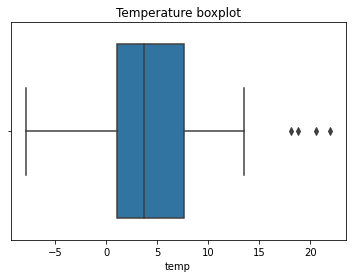

In [23]:
sns.boxplot(x='temp',data=we)
plt.title('Temperature boxplot')
plt.show()

Temperatures spans from -8°C to 22°C, mean temperature around 4.5°C

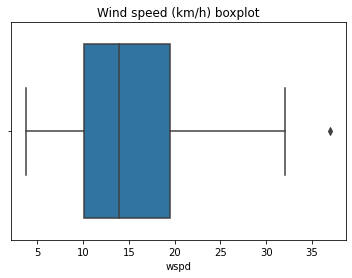

In [24]:
sns.boxplot(x='wspd',data=we)
plt.title('Wind speed (km/h) boxplot')
plt.show()

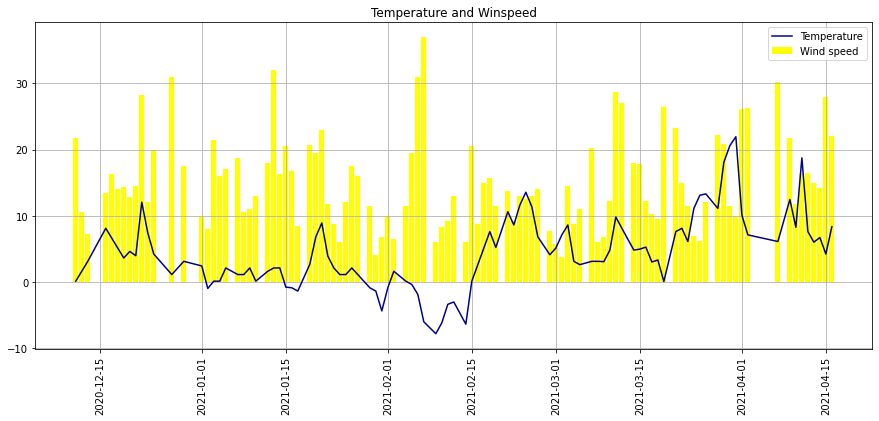

In [25]:
fig, ax = plt.subplots(figsize=(15,6)) 
ax.plot(we.date,we.temp, color='darkblue',label='Temperature')
ax.bar(we.date,we.wspd,color='yellow',label='Wind speed')
plt.title('Temperature and Winspeed')
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

Berlin it is a windy city. To be noted that the windiest day coincides also with the coldest (these day were punk), we can also observe that after mid-February the temperature raised and got considerably warmer.

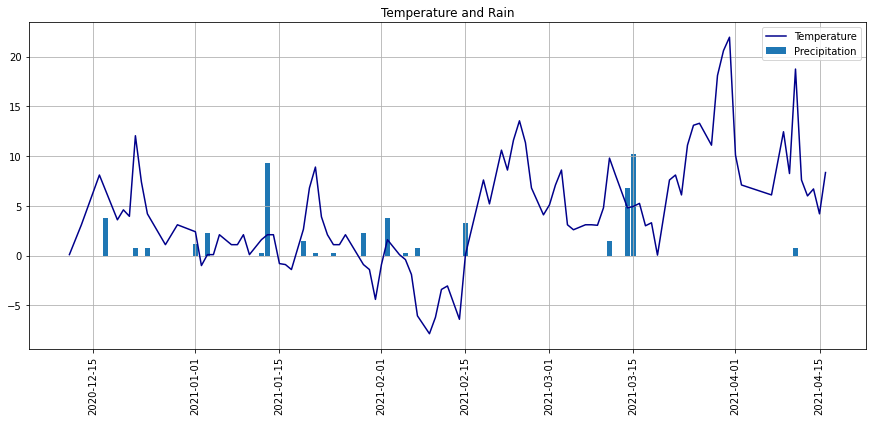

In [26]:
fig, ax = plt.subplots(figsize=(15,6)) 
ax.plot(we.date,we.temp, color='darkblue',label='Temperature')
ax.bar(we.date,we.prcp*15,label='Precipitation') #multiply per 15 just for visualisation

plt.title('Temperature and Rain')
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

Luckily enough I didn't expect heavy rainfall. During that winter weather was mostly cloudy or overcast without any major form of precipitation.

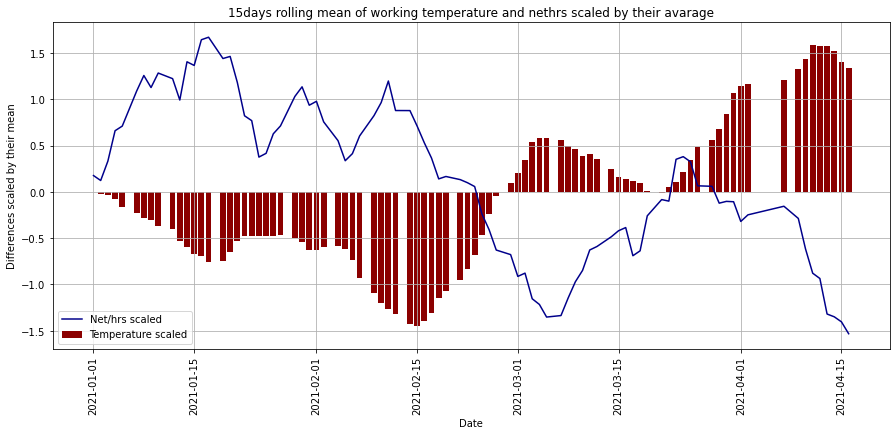

In [27]:
def rolmeantemp(x,y,y1,w,z,z1):
    y,y1=y-y.mean(),y1-y1.mean()
    fig, ax = plt.subplots(figsize=(15,6)) 
    rol_meany=y.rolling(w).mean()
    rol_meany1=y1.rolling(w).mean()
    ax.plot(x,rol_meany, color='darkblue',label=z)
    ax.bar(x,rol_meany1, color='darkred', label='Temperature scaled')
    plt.xlabel('Date')
    plt.ylabel('Differences scaled by their mean')
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend()
    plt.title(z1)
    plt.savefig('plot.png', dpi=300, bbox_inches='tight')
    plt.show()
rolmeantemp(we.date,df.nethrs,we.temp/5,15,
            'Net/hrs scaled',
            '15days rolling mean of working temperature and nethrs scaled by their avarage')

These graph is made by scaling the rolling mean of Net/hrs and temperature with their avarage.
It is highly informative because we can clearly see that temperature and Net/hrs are negative correlated. The more the temperature drop below its avarage(4.5°C), the more my earning per hour rise above its avarage (12.91 €/h).

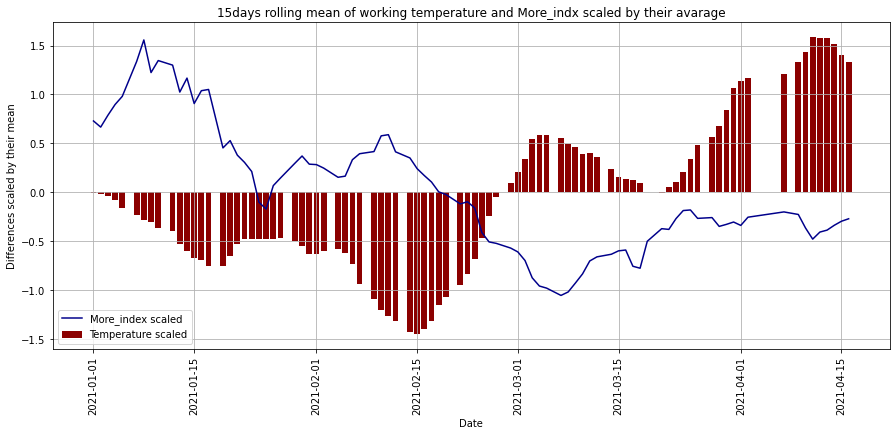

In [28]:
rolmeantemp(we.date,we.more,we.temp/5,15,
            'More_index scaled','15days rolling mean of working temperature and More_indx scaled by their avarage')

In the same way as the previous graph also 'More' index is negative correlated with temperature.
The lower the temperature the higher the desire from customer to stay home and have their food delivered. As the previous graph, the more the temperature dropped below its avarage (4.5°C), the more I was earning over 10€/hr.

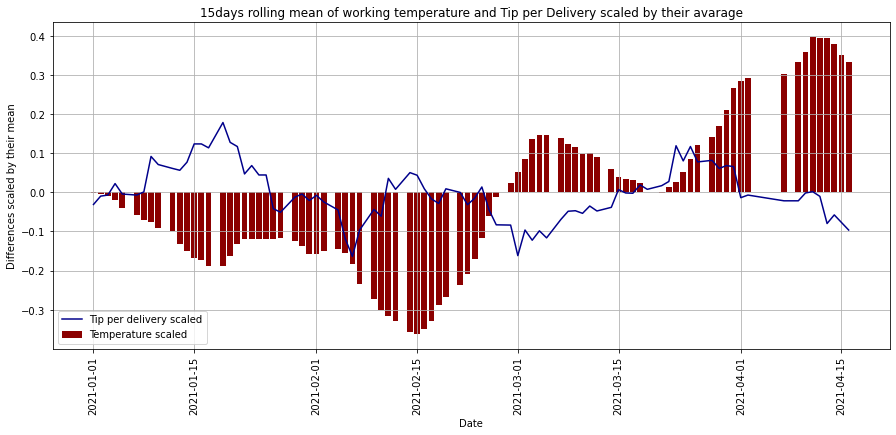

In [29]:
rolmeantemp(we.date,we.tipdel,we.temp/20,15,
            'Tip per delivery scaled','15days rolling mean of working temperature and Tip per Delivery scaled by their avarage')

Temperature variable is not able to explain the tip per delivery parameter.
The general idea that the courier earn more Tips with cold temperature is incorrect.


In [30]:
td=pd.DataFrame()
td['temp']=we.temp
td.loc[td['temp'] <0 , 'class'] = 'under0' #adding 4 different temperature class
td.loc[(td['temp'] >=0)&(td['temp'] <4) , 'class'] = '0-4'
td.loc[(td['temp'] >=4)&(td['temp'] <8) , 'class'] = '4-8'
td.loc[td['temp'] >=8 , 'class'] = 'over8'
td['nethrs']=we.nethrs
ind=td.groupby('class').mean().sort_values(by=['temp'])['nethrs'].index.tolist()

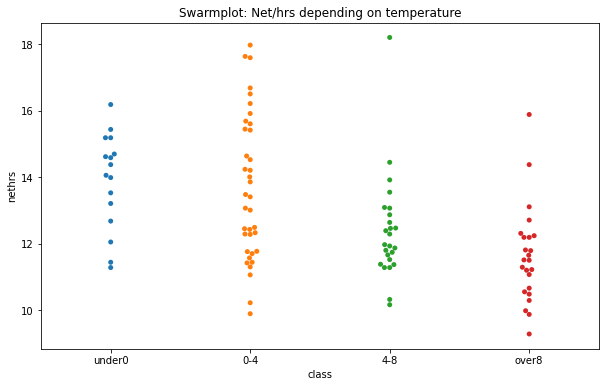

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
sns.swarmplot(x=td['class'],y=td['nethrs'],order=ind)
plt.title('Swarmplot: Net/hrs depending on temperature')
plt.show()

In [32]:
print('Tips per delivery depending on temperature: ')
td.groupby('class').median().sort_values(by=['temp'])['nethrs']

Tips per delivery depending on temperature: 


class
under0    14.220
0-4       13.410
4-8       11.970
over8     11.505
Name: nethrs, dtype: float64

# COCO Weather COndition COde

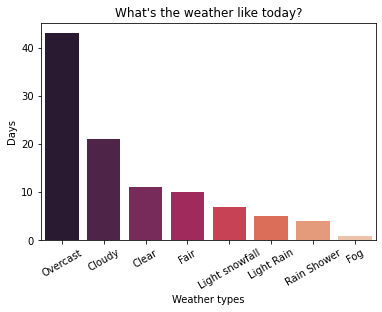

In [33]:
ordercoco=('Overcast','Cloudy','Clear','Fair','Light snowfall','Light Rain','Rain Shower','Fog')
g=sns.countplot(x='coco',order=ordercoco, palette="rocket",data=we,)
g.set_xticklabels(labels=ordercoco,rotation=30)
plt.title('''What's the weather like today?''')
plt.xlabel('Weather types')
plt.ylabel('Days')
plt.show()

Days during the winter could be tremendously gray and boring.
We will group together:
* 'Overcast', 'Cloudy' and 'Fog' into 'Cloudy'
* 'Clear' and 'Fair' into 'Clear'
* 'Light snowfall', 'Light Rain' and 'Rain shower' into 'Precipitation'

in order to have more elements inside a group.



In [34]:
wef=we.copy()
wef.loc[(wef.coco=='Overcast') | (wef.coco=='Cloudy') | (wef.coco=='Fog'), 'coco']='Cloudy'

In [35]:
wef.loc[(wef.coco=='Clear') | (wef.coco=='Fair'),'coco']='Clear'

In [36]:
wef.loc[(wef.coco=='Light snowfall') | (wef.coco=='Light Rain') | (wef.coco=='Rain Shower'),'coco']='Precipitation'

<AxesSubplot:title={'center':'Counts of day by weather type'}, ylabel='day'>

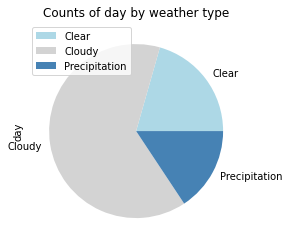

In [37]:
wef.groupby(['coco']).count().plot(kind='pie', y='day',
                                  colors = ['lightblue', 'lightgrey', 'steelblue'],
                                  title='Counts of day by weather type')

In [38]:
wef.coco.value_counts()

Cloudy           65
Clear            21
Precipitation    16
Name: coco, dtype: int64

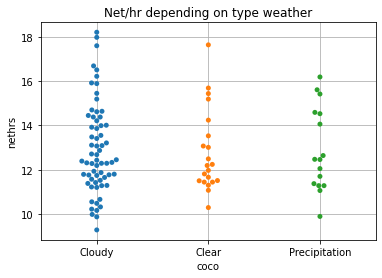

In [39]:
sns.swarmplot(x=wef['coco'],y=wef['nethrs'] )
plt.title('Net/hr depending on type weather')
plt.grid()
plt.show()

In [40]:
wef.groupby('coco')['nethrs'].median().sort_values()

coco
Clear            12.190
Cloudy           12.430
Precipitation    12.465
Name: nethrs, dtype: float64

In [41]:
wef.groupby('coco')['nethrs'].mean().sort_values()

coco
Clear            12.796190
Precipitation    12.912500
Cloudy           12.948769
Name: nethrs, dtype: float64

From this limited dataset appears clear that weather typology is not supposed to affect my earnings. 'With rain courier earns more' is just a mith.


In [42]:
(pd.DataFrame([pr['class'].value_counts()[1], pr['class'].value_counts()[0]],
              index=['NoRain','Rain'])).plot(kind='pie',subplots=True)

NameError: name 'pr' is not defined

In [ ]:
sns.swarmplot(x=pr['class'],y=pr['nethrs'])
plt.title('Net/hrs depending on precipitation')
plt.grid()
plt.show()

In [ ]:
ax=sns.boxplot(x=pr['class'],y=pr['nethrs'])
plt.title('Boxplot: Net/hrs depending on precipitation')
plt.show()

In [ ]:
print('Net/hrs depending on precipitation: \n',
      pr.groupby('class').median().sort_values(by=['prcp'])['nethrs'],'\n')

Interestingly, there is no difference between rainy and not rainy days in the Net/hrs parameter.

# Is the change the one that matters?
My idea was that customers were sensitive not only to the temperature itself, but also to its change. 

That is, the perception of heat and cold (and therefore the desire to stay at home and order food from their smartphone) were not absolute per se but relative.



In [ ]:
diff=pd.DataFrame() #create a new dataframe diff with the difference of temperature,nethrs, more and tipdel
diff['date']=we.date
diff['dtemp']=we.temp.diff()
diff['dnethrs']=we.nethrs.diff()
diff['dmore']=we.more.diff()
diff['ddel']=we.deliveries.diff()
diff['dtipdel']=we.tipdel.diff()  
diff=diff.iloc[1:]


Since I've not worked every consecutive day I should before filtering the non consecutive days, because in those days the weather could have changed a lot.

In [ ]:
l=[]
for el in we.date.diff().dt.days:
    if el ==1: #mean that is consecutive
        l.append(True)
    else:
        l.append(False)
l=l[1:]
len(diff)-len(diff[l])

We loose 19 days (when I was taking a break from work) but we improve the analysis

In [ ]:
diff=diff[l]
diff.corr().style.background_gradient(cmap='coolwarm')

In [ ]:
def rgplt(df,x,y,z):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x],df[y])
    ax=sns.regplot(x=x,y=y,data=df, line_kws={'label':"y= R= {0:.3f}, p_val={1: .3f}".format(r_value,p_value)})
    ax.legend()
    plt.title(z)
    plt.show()
rgplt(diff,'dtemp','dnethrs','Temperature change and Net/hrs change')

Sadly the R value is very low, also the p-value of 0.18 suggest that there's little or no correlation and thus makes me rejecting my hypotesis that I was earning more when the temperature dropped from a day to another.

In [ ]:
rgplt(diff,'dtemp','dmore','Temperature change and More index change')

No correlation at all among the change of the temperature and the change of 'More' index between days.

In [ ]:
rgplt(diff,'dtemp','dtipdel','Temperature change and Tip per delivery change')

Very little or no correlation among the change of the temperature and the change of tip per deleivery between consecutive days

## Using machine learning to determine wich weather variable had higher influence on Net/hrs variable

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix, classification_report

In [ ]:
features=['temp','rhum','prcp','wspd','wpgt','pres'] 
x=we[features]
y=we.nethrs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#20% of the data they will be the test 80% train

In [ ]:
Trfmodel = RandomForestRegressor(random_state=1)
Trfmodel.fit(x_train,y_train)
rfpred= Trfmodel.predict(x_test)
mean_absolute_error(y_test,rfpred).round(3)

The model on avarage has an error of 1.2€ when predicts net/hrs variable

In [ ]:
importances = Trfmodel.feature_importances_
indices = np.argsort(importances)
features = x_train.columns

In [ ]:
plt.title('Feature Importance model Net/hrs')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(features)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We see what we already know: 
* Temperature seems to have a major role determing the value of Net/hrs (the parameter that is influenced the most by weather)
* Also rhum (relative humidity) seems to play a contribute, we should remember though that this parameter it is heavily influenced by temperature.
* It is difficult to say if the other parameter are useful and statistical relevant predicitors.
* It is interesting realise how little precipitation parameter is contributing to determine Net/hrs.